# Generación de texto con una red recurrente

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

import librosa

import matplotlib.pyplot as plt
import soundfile as sf

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
filename = librosa.example('nutcracker')

In [4]:
y, sr = librosa.load(filename)

In [5]:
len(y)

2643264

Normalise the data

In [6]:
scaler = StandardScaler()

In [7]:
scaler.fit(y.reshape(-1, 1))

StandardScaler()

In [8]:
y_scaled = scaler.transform(y.reshape(-1, 1))
y_shifted = y_scaled-np.min(y_scaled)

In [9]:
ynew = y_shifted.reshape(-1)

In [10]:
len(ynew)

2643264

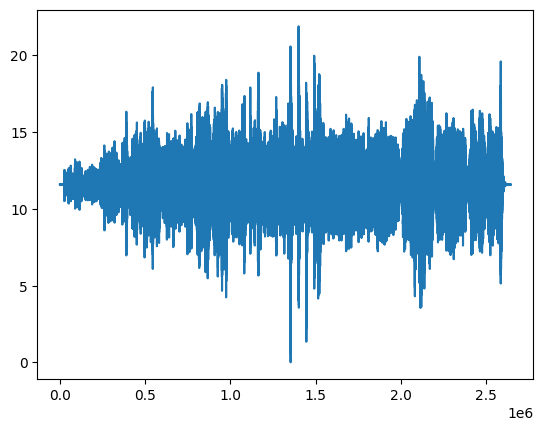

In [11]:
plt.plot(ynew)

In [12]:
ynew2 = np.round(ynew, decimals=2)

In [13]:
from IPython.display import Audio

In [14]:
Audio(data=ynew2, rate=sr)

In [15]:
vocab = sorted(set(ynew2))

In [16]:
print(f'{len(vocab)} carácteres únicos')

1624 carácteres únicos


In [17]:
all_values = tf.data.Dataset.from_tensor_slices(ynew2)

In [18]:
length_seq = 100

In [19]:
sequences = all_values.batch(length_seq+1, drop_remainder=True)

In [20]:
def divide_input_output(sequence):
    music_input = sequence[:-1]
    music_output = sequence[1:]
    return music_input, music_output

In [21]:
dataset = sequences.map(divide_input_output)

In [22]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.float32, name=None))>

In [23]:
# Size of the batches
BATCH = 64

# Buffer size for shuffling the data
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [24]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.float32, name=None), TensorSpec(shape=(64, 100), dtype=tf.float32, name=None))>

In [25]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_units = 1024

In [26]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [27]:
model = MyModel(vocab_size=vocab_size,
                  embedding_dim=embedding_dim,
                  rnn_units=rnn_units)

In [28]:
for example_input_batch, example_output_batch in dataset.take(1):
    example_predictions_batch = model(example_input_batch)
    print(example_predictions_batch.shape, "# (batch, sequence, vocab)")

(64, 100, 1624) # (batch, sequence, vocab)


In [29]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  415744    
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  1664600   
                                                                 
Total params: 6018648 (22.96 MB)
Trainable params: 6018648 (22.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
indices_sample = tf.random.categorical(example_predictions_batch[0], num_samples=1)

In [31]:
indices_sample = tf.squeeze(indices_sample, axis=-1).numpy()

In [32]:
indices_sample

array([ 674,  466, 1163,  222, 1499,  804,  810, 1129,  469,  802,  582,
       1268,  945,  668,  803, 1390, 1093,  353,  671,  775,  797, 1468,
        562,  961, 1404,  500, 1275, 1448, 1411,  173,  156, 1036,  735,
        875, 1552,  132, 1232, 1516,  347,  576,  568, 1053,  182,  748,
       1295,  367, 1368,  482,  656,  949, 1336, 1502,  537,  577,  664,
       1613,  463,  741,  218, 1345,  160,  773,  844, 1251,   25, 1040,
       1313,  946, 1274,  633,  486, 1028,  933, 1578, 1187,   93,  821,
        404, 1466, 1368, 1131,  353,  302,   11, 1083, 1168,  900, 1084,
        513,  469, 1270, 1238,  440,  411,  942,  625, 1569,  545, 1268,
       1098])

In [33]:
for idx in indices_sample:
    print(vocab[idx])

9.91
7.83
14.8
5.39
18.19
11.21
11.27
14.46
7.86
11.19
8.99
15.85
12.62
9.85
11.2
17.07
14.1
6.7
9.88
10.92
11.14
17.86
8.79
12.78
17.21
8.17
15.92
17.66
17.28
4.89
4.67
13.53
10.52
11.92
18.81
4.34
15.49
18.38
6.64
8.93
8.85
13.7
4.98
10.65
16.12
6.84
16.85
7.99
9.73
12.66
16.53
18.22
8.54
8.94
9.81
21.06
7.8
10.58
5.35
16.62
4.71
10.9
11.61
15.68
1.71
13.57
16.3
12.63
15.91
9.5
8.03
13.45
12.5
19.47
15.04
3.55
11.38
7.21
17.84
16.85
14.48
6.7
6.19
0.93
14.0
14.85
12.17
14.01
8.3
7.86
15.87
15.55
7.57
7.28
12.59
9.42
19.12
8.62
15.85
14.15


In [34]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [35]:
example_batch_average_loss = loss(example_input_batch, example_predictions_batch)

In [36]:
print("Average loss: ", example_batch_average_loss)

Average loss:  tf.Tensor(7.39721, shape=(), dtype=float32)


In [37]:
tf.exp(example_batch_average_loss).numpy()

1631.4265

In [38]:
model.compile(optimizer='adam', loss=loss)

In [39]:
checkpoint_dir = './training_checkpoints'

In [40]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [41]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [42]:
EPOCHS = 10

In [43]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
408/408 [==============================] - 37s 77ms/step - loss: 0.7324
Epoch 2/10
408/408 [==============================] - 35s 81ms/step - loss: 0.5136
Epoch 3/10
408/408 [==============================] - 34s 80ms/step - loss: 0.5000
Epoch 4/10
408/408 [==============================] - 35s 81ms/step - loss: 0.4955
Epoch 5/10
408/408 [==============================] - 35s 80ms/step - loss: 0.4922
Epoch 6/10
408/408 [==============================] - 35s 80ms/step - loss: 0.4900
Epoch 7/10
408/408 [==============================] - 34s 81ms/step - loss: 0.4876
Epoch 8/10
408/408 [==============================] - 35s 81ms/step - loss: 0.4861
Epoch 9/10
408/408 [==============================] - 34s 80ms/step - loss: 0.4847
Epoch 10/10
408/408 [==============================] - 35s 81ms/step - loss: 0.4831


In [46]:
@tf.function
def generate_step(inputs, states=None):
    # Execute the model
    # logits_predicted.shape is [batch, values, logits_next_value]
    logits_predicted, states = model(inputs=inputs,
                                            states=states,
                                            return_state=True)
    # Use only the last prediction
    logits_predicted = logits_predicted[:, -1, :]
    logits_predicted = logits_predicted/self.temperature

    # Get output sample
    predictions = tf.random.categorical(logits_predicted, num_samples=1)
    predictions = tf.squeeze(predictions, axis=-1)

    # Go from indices to values
    values_predicted = vocab[predictions]

    return values_predicted, states

In [ ]:
start = time.time()
states = None
next_values = tf.constant()
result = [next_values]

for n in range(1000):
    next_values, states = generate_step(inputs, states=states)
    result.append(next_values)

final = time.time()